In [1]:
##################################################################################################################
# Let us start by installing SCL and tensorflow_compress library
##################################################################################################################

%%bash
# Define the directory path
stanford_compression_library="/content/stanford_compression_library"

# Check if the directory exists, don't clone again.
if [ ! -d "$stanford_compression_library" ]; then
  # Clone the repository
  git clone https://github.com/kedartatwawadi/stanford_compression_library.git "$stanford_compression_library"
fi

cd "$stanford_compression_library"
echo $PWD
pip install -e .

# Installs the latest version of TFC compatible with the installed TF version.
read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip -q install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

/content/stanford_compression_library
Obtaining file:///content/stanford_compression_library
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 58.8 MB/s eta 0:00:00
  Running setup.py develop for stanford-compression-library
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 4.6 MB/s eta 0:00:00


Cloning into '/content/stanford_compression_library'...


In [2]:
##################################################################################################################
# Add SCL to the system path, and then import relevant libraries
##################################################################################################################

# add scl to the path
import sys
sys.path.insert(1, "stanford_compression_library")

# import other packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from scipy.stats import norm
from scl.core.prob_dist import Frequencies
from scl.core.data_block import DataBlock
from scl.compressors.arithmetic_coding import AECParams, ArithmeticEncoder, ArithmeticDecoder
from scl.compressors.probability_models import FixedFreqModel

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


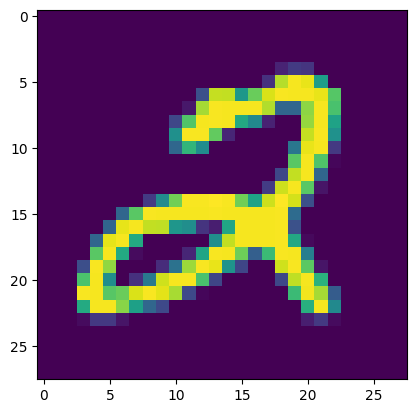

In [3]:
##################################################################################################################
# We will be working with the MNIST digit dataset.
# Lets download the dataset and display a sample image
# 1. MNIST images are 28x28x1 grayscale
##################################################################################################################

training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

# the validation_dataset.take(1) returns one sample
# it also returns the label of the digit, which we don't care for
(x, _), = validation_dataset.take(1)
plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")

In [4]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


In [5]:
def preprocess_img(x):
  # Ensure inputs are floats in the range (0, 1).
  x = tf.cast(x, tf.float32) / 255.
  x = tf.reshape(x, (-1, 28, 28, 1))
  return x

def postprocess_img(x_hat):
  return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def l1_loss(x,x_hat):
  return tf.reduce_mean(abs(x - x_tilde))

Data type: <dtype: 'float32'>
Shape: (1, 28, 28, 1)
distortion: tf.Tensor(0.1703435, shape=(), dtype=float32)


Text(0.5, 1.0, 'Reconst')

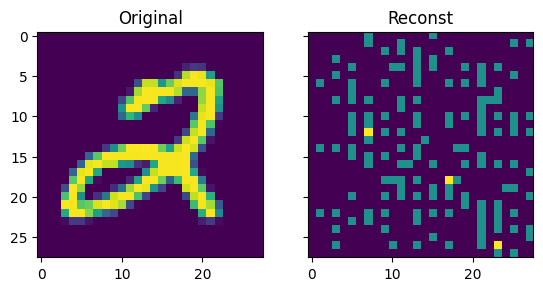

In [6]:
## Lets consider a sample input
(x, _), = validation_dataset.take(1)
x = preprocess_img(x)
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")

### Let's define the analysis and synthesis transforms
# and try to see how the un-trained transform transforms the input
analysis_transform = make_analysis_transform(latent_dims=50)
y = analysis_transform(x)
# print(analysis_transform.summary())

synthesis_transform = make_synthesis_transform()
x_tilde = synthesis_transform(y)
# print(synthesis_transform.summary())

# Mean absolute difference across pixels.
print("distortion:", l1_loss(x,x_tilde))

## plot the original and the reconstructed image
x_tilde = postprocess_img(x_tilde)
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(tf.squeeze(x))
ax1.set_title('Original')
ax2.imshow(tf.squeeze(x_tilde))
ax2.set_title('Reconst')

In [7]:
def estimated_rate_loss(prior_dist, y, width=1.0):
  """
  Neg entropy loss
  """
  half_width = width/2.0
  prob = prior_dist.cdf(y+half_width) - prior_dist.cdf(y-half_width)
  neg_log_prob = -tf.reduce_sum(tf.math.log(prob)/tf.math.log(2.0), axis=(1))
  return neg_log_prob

class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior = tfp.distributions.Normal(loc=0., scale=1.)

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = preprocess_img(x)

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)

    ################################################################################
    # Workaround - 1
    # add noise
    noise = tf.random.uniform(tf.shape(y), minval=-.5, maxval=.5)
    y_tilde = y + noise
    ################################################################################

    # Average number of bits per MNIST digit.
    ################################################################################
    # Workaround-2
    rate_loss = estimated_rate_loss(self.prior, y_tilde)
    rate_loss = tf.reduce_mean(rate_loss)
    ################################################################################


    ## run the synthesis transform
    x_tilde = self.synthesis_transform(y_tilde)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))
    return dict(rate=rate_loss, distortion=distortion)

In [8]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(latent_dims=10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])

rate:  tf.Tensor(14.4410515, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14787279, shape=(), dtype=float32)


In [10]:
def make_mnist_compression_trainer(lmbda, latent_dims):
  pass_through_loss = lambda _,x: x
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda, latent_dims):
  trainer = make_mnist_compression_trainer(lmbda, latent_dims)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer


### train the model
trainer = train_mnist_model(lmbda=2000, latent_dims=50)

Epoch 1/15
469/469 [==============================] - 116s 239ms/step - loss: 209.9631 - distortion_loss: 0.0636 - rate_loss: 82.7572 - distortion_<lambda>: 0.0636 - rate_<lambda>: 82.7588 - val_loss: 174.3185 - val_distortion_loss: 0.0440 - val_rate_loss: 86.4029 - val_distortion_<lambda>: 0.0440 - val_rate_<lambda>: 86.4108
Epoch 2/15
469/469 [==============================] - 89s 191ms/step - loss: 169.1543 - distortion_loss: 0.0414 - rate_loss: 86.3570 - distortion_<lambda>: 0.0414 - rate_<lambda>: 86.3567 - val_loss: 163.8121 - val_distortion_loss: 0.0386 - val_rate_loss: 86.5163 - val_distortion_<lambda>: 0.0386 - val_rate_<lambda>: 86.5164
Epoch 3/15
469/469 [==============================] - 93s 198ms/step - loss: 162.0137 - distortion_loss: 0.0376 - rate_loss: 86.7141 - distortion_<lambda>: 0.0376 - rate_<lambda>: 86.7138 - val_loss: 159.1349 - val_distortion_loss: 0.0362 - val_rate_loss: 86.6751 - val_distortion_<lambda>: 0.0362 - val_rate_<lambda>: 86.6875
Epoch 4/15
469/469

In [11]:
def get_frequencies_from_prior(prior_dist, min_val=-4, max_val=4, freq_scale=1 << 16):
  freq_dict = {}

  # iterate over the integers we get after quantization
  for i in range(min_val,max_val+1):
    prob = prior_dist.cdf(i+0.5) - prior_dist.cdf(i-0.5)
    freq_dict[int(i)] = int(freq_scale*prob)
  print(f'Frequency Dictionary: {freq_dict}\n')
  freq = Frequencies(freq_dict)
  return freq

class MNISTEncoder:
  """Compresses MNIST images to bits"""

  def __init__(self, analysis_transform):
    super().__init__()
    self.analysis_transform = analysis_transform

    # set min_val, max_val for codelayer
    # (these values are set, so that the probability is not too close to 0)
    self.min_val = -4
    self.max_val = 4
    self.prior = tfp.distributions.Normal(loc=0., scale=1.)

    # define arithmetic encoder
    aec_params = AECParams(DATA_BLOCK_SIZE_BITS=8)

    freq = get_frequencies_from_prior(self.prior, self.min_val, self.max_val)
    freq_model = FixedFreqModel(freqs_initial=freq,
                                max_allowed_total_freq=aec_params.MAX_ALLOWED_TOTAL_FREQ)

    self.aec_enc = ArithmeticEncoder(aec_params, freq_model)

  def encode_image(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = preprocess_img(x)

    # get output of y from the analysis transform
    y = self.analysis_transform(x)

    # clip y to be between min_val and max_val, as
    # those extreme values have probabilities too low
    y = tf.clip_by_value(y, self.min_val-0.5, self.max_val+0.5)

    # quantize y by simple rounding
    y_quant = tf.math.round(y)

    # encode using aec
    data = DataBlock([int(z) for z in y_quant[0].numpy()])
    bitarray = self.aec_enc.encode_block(data)
    return bitarray, y_quant


class MNISTDecoder:
  """Compresses MNIST images to bits"""

  def __init__(self, synthesis_transform):
    super().__init__()
    self.synthesis_transform = synthesis_transform

    # set min_val, max_val for codelayer
    # (these values are set, so that the probability is not too close to 0)
    self.min_val = -4
    self.max_val = 4
    self.prior = tfp.distributions.Normal(loc=0., scale=1.)

    # define arithmetic decoder
    aec_params = AECParams(DATA_BLOCK_SIZE_BITS=8)
    freq = get_frequencies_from_prior(self.prior, self.min_val, self.max_val)
    freq_model = FixedFreqModel(freqs_initial=freq,
                                max_allowed_total_freq=aec_params.MAX_ALLOWED_TOTAL_FREQ)
    self.aec_dec = ArithmeticDecoder(aec_params, freq_model)

  def decode_image(self, enc_bitarray):
    # decode
    data_block,_ = self.aec_dec.decode_block(enc_bitarray)
    y_quant = tf.convert_to_tensor(data_block.data_list,dtype=tf.float32)
    y_quant = tf.expand_dims(y_quant, axis=0)
    x_hat = self.synthesis_transform(y_quant)

    # Scale and cast back to 8-bit integer.
    return postprocess_img(x_hat)

In [12]:
enc = MNISTEncoder(trainer.analysis_transform)
dec = MNISTDecoder(trainer.synthesis_transform)


def encode_decode_images(originals, enc, dec, verbose=False):
  enc_bitarrays = []
  reconstructions = []
  codelayers = []
  y_quantized = []

  for img in originals:
    img = tf.expand_dims(img, axis=0)
    enc_bitarray, y_quant = enc.encode_image(img)

    # store quantized values for plotting
    y_quantized.extend(y_quant)

    rate = len(enc_bitarray) - enc.aec_enc.params.DATA_BLOCK_SIZE_BITS

    estimated_rate = estimated_rate_loss(enc.prior, y_quant)

    reconst = dec.decode_image(enc_bitarray)
    distortion = tf.reduce_mean(abs(tf.cast(reconst,tf.float32)-tf.cast(img,tf.float32))/255.0)
    codelayers.append(y_quant[0])
    reconstructions.append(reconst)
    enc_bitarrays.append(enc_bitarray)

    if verbose:
      print(f"final rate: {rate}, Estimated rate: {float(estimated_rate):.3f}, final_distortion: {distortion:.3f}, ")

  return enc_bitarrays, reconstructions, codelayers, y_quantized

(originals, _), = validation_dataset.batch(16).skip(3).take(1)
print(originals.shape)
enc_bitarrays, reconstructions, codelayers, y_quantized = encode_decode_images(originals, enc, dec, verbose=True)

Frequency Dictionary: {-4: 15, -3: 391, -2: 3971, -1: 15842, 0: 25095, 1: 15842, 2: 3971, 3: 391, 4: 15}

Frequency Dictionary: {-4: 15, -3: 391, -2: 3971, -1: 15842, 0: 25095, 1: 15842, 2: 3971, 3: 391, 4: 15}

(16, 28, 28, 1)
final rate: 88, Estimated rate: 87.162, final_distortion: 0.028, 
final rate: 83, Estimated rate: 81.853, final_distortion: 0.014, 
final rate: 90, Estimated rate: 88.505, final_distortion: 0.032, 
final rate: 84, Estimated rate: 82.517, final_distortion: 0.013, 
final rate: 86, Estimated rate: 84.513, final_distortion: 0.017, 
final rate: 88, Estimated rate: 86.504, final_distortion: 0.030, 
final rate: 93, Estimated rate: 91.159, final_distortion: 0.029, 
final rate: 88, Estimated rate: 86.504, final_distortion: 0.024, 
final rate: 92, Estimated rate: 90.496, final_distortion: 0.029, 
final rate: 94, Estimated rate: 93.145, final_distortion: 0.030, 
final rate: 101, Estimated rate: 99.134, final_distortion: 0.043, 
final rate: 95, Estimated rate: 93.819, final

In [13]:
#@title
def display_digits(originals, strings, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→\n{(len(strings[i]) - 8)} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

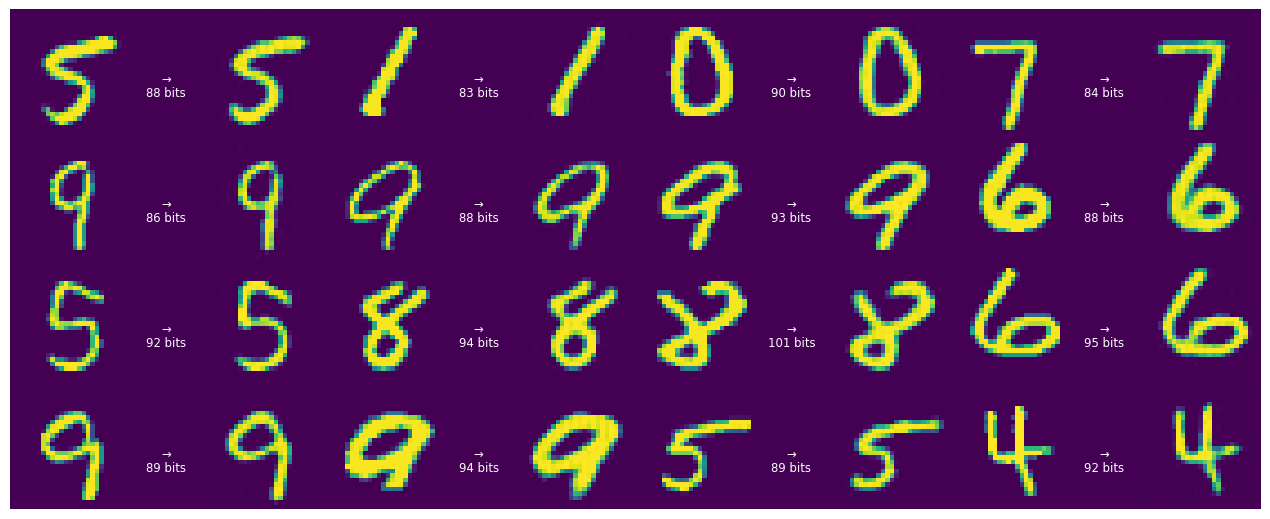

In [14]:
display_digits(originals, enc_bitarrays, reconstructions)

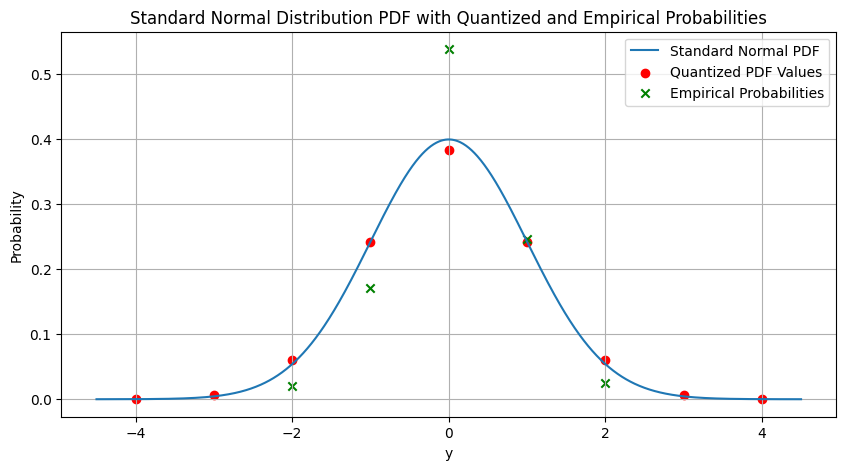

In [15]:
# Define the range for x
x = np.linspace(-4.5, 4.5, 1000)

# Calculate the PDF of the standard normal distribution
pdf = norm.pdf(x, 0, 1)

# Quantize the PDF at integer points
int_points = np.arange(-4, 5)
int_pdf_values = norm.cdf(int_points+0.5, 0, 1) - norm.cdf(int_points-0.5, 0, 1)

# Get y_quantized from compression model and plot them

y_quantized = np.concatenate([tensor.numpy() for tensor in y_quantized])
unique, counts = np.unique(y_quantized, return_counts=True)
empirical_probabilities = counts / y_quantized.size

# Plot the empirical probabilities on the previous PDF plot
plt.figure(figsize=(10, 5))
plt.plot(x, pdf, label='Standard Normal PDF')  # Standard Normal PDF
plt.scatter(int_points, int_pdf_values, color='red', label='Quantized PDF Values')  # Quantized values

# Plot the empirical probabilities
plt.scatter(unique, empirical_probabilities, color='green', marker='x', label='Empirical Probabilities')

# # Annotate the empirical probabilities
# for i, txt in enumerate(empirical_probabilities):
#     plt.annotate(f'{txt:.2f}', (unique[i], empirical_probabilities[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and title
plt.title('Standard Normal Distribution PDF with Quantized and Empirical Probabilities')
plt.xlabel('y')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/15
469/469 [==============================] - 123s 257ms/step - loss: 70.4503 - distortion_loss: 0.0757 - rate_loss: 32.6077 - distortion_<lambda>: 0.0757 - rate_<lambda>: 32.6084 - val_loss: 62.7710 - val_distortion_loss: 0.0576 - val_rate_loss: 33.9705 - val_distortion_<lambda>: 0.0576 - val_rate_<lambda>: 33.9759
Epoch 2/15
469/469 [==============================] - 95s 203ms/step - loss: 61.7088 - distortion_loss: 0.0552 - rate_loss: 34.0972 - distortion_<lambda>: 0.0552 - rate_<lambda>: 34.0972 - val_loss: 60.5238 - val_distortion_loss: 0.0526 - val_rate_loss: 34.2188 - val_distortion_<lambda>: 0.0526 - val_rate_<lambda>: 34.2273
Epoch 3/15
469/469 [==============================] - 94s 201ms/step - loss: 60.0675 - distortion_loss: 0.0517 - rate_loss: 34.2382 - distortion_<lambda>: 0.0517 - rate_<lambda>: 34.2380 - val_loss: 59.3476 - val_distortion_loss: 0.0501 - val_rate_loss: 34.3148 - val_distortion_<lambda>: 0.0501 - val_rate_<lambda>: 34.3152
Epoch 4/15
469/469 [====

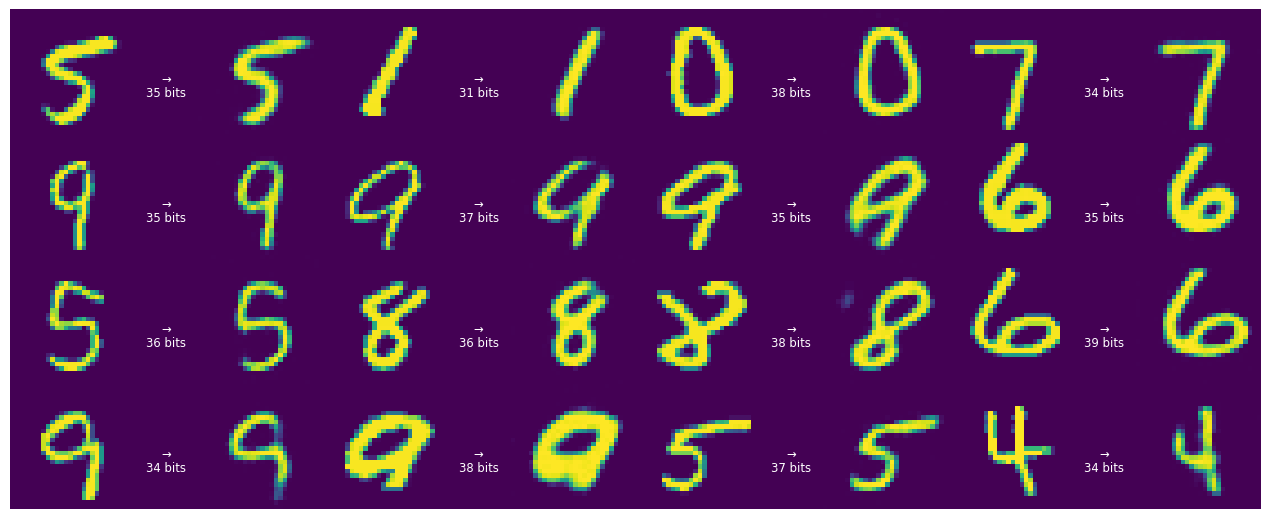

In [18]:
def train_and_visualize_model(lmbda, latent_dims):
  trainer = train_mnist_model(lmbda=lmbda, latent_dims=latent_dims)
  enc = MNISTEncoder(trainer.analysis_transform)
  dec = MNISTDecoder(trainer.synthesis_transform)
  enc_bitarrays, reconstructions, codelayers, y_quantized = encode_decode_images(originals, enc, dec, verbose=True)
  display_digits(originals, enc_bitarrays, reconstructions)

train_and_visualize_model(lmbda=500, latent_dims=20)